## Load Imports

In [64]:
# Load necessary packages
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rioxr
import requests
import zipfile
import fiona
import io
from shapely.geometry import shape

# URL of the ZIP file containing the shapefile
url = 'https://gis.data.cnra.ca.gov/api/download/v1/items/e3802d2abf8741a187e73a9db49d68fe/shapefile?layers=0'

# Directory for downloaded data
data_dir = 'data'
os.makedirs(data_dir, exist_ok = True)

# File paths
zip_file_path = os.path.join(data_dir, 'fire_perimeter.zip')
shapefile_dir = os.path.join(data_dir, 'fire_perimeter')


# Task 2: Visualizing fire perimeter of Thomas fire

## Instructions

- First, update the following cell to have a link to *your* Homework 3 GitHub repository:

**UPDATE THIS LINK**
https://github.com/takeenshamloo/eds220-hwk4


- Review the [complete rubric for this task](https://docs.google.com/document/d/1-Zm731BLVCs1MXHT5R1H9rr6uvcwHnMZQ2q8xkQ_fWM/edit?tab=t.0) before starting.

- **Meaningful commits should be made every time you finish a major step.** We'll check your repository and view the commit history.

- Comment mindfully in a way that enriches your code. Comments should follow best practices.

- **Do not update the top cell with the `otter` import**, this is used internally for grading.

- Delete all the comments initially included in this notebook (ex: `# Your code here`).


## About the data

For our data we will be reading in Thomas Fire Data from 2017 and outlining the perimeter of the fire.

## Section 1: Download and Extract Fire Perimeter Data

In this section, we will download the fire perimeter shapefile from the provided URL and extract it for further analysis.



In [80]:
# Download the ZIP file
if not os.path.exists(zip_file_path):
    print("Downloading fire perimeter data...")
    response = requests.get(url)
    with open(zip_file_path, 'wb') as f:
        f.write(response.content)
    print("Download complete.")

# Extract the ZIP file
if not os.path.exists(shapefile_dir):
    print("Extracting shapefile...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(shapefile_dir)
    print("Extraction complete.")

# List extracted files
extracted_files = os.listdir(shapefile_dir)
print("Extracted files:", extracted_files)

Extracted files: ['California_Fire_Perimeters_(all).prj', 'California_Fire_Perimeters_(all).dbf', 'California_Fire_Perimeters_(all).shp.xml', 'California_Fire_Perimeters_(all).shx', 'California_Fire_Perimeters_(all).cpg', 'California_Fire_Perimeters_(all).shp']


## Section 2: Load Fire Perimeter Data

Here, we will load the extracted fire perimeter shapefile and explore its attributes.

In [81]:
# Important note:
# This code was written on my own VSCode python environment
# gpd.read_file was having issues with the fiona package and a path attribute
# There was a version conflict for my geopandas and fiona sub package so I routed to use fiona directly

# Read shapefile with Fion
shapefile_path = "data/fire_perimeter/California_Fire_Perimeters_(all).shp"
with fiona.open(shapefile_path, "r") as shapefile:
    records = [feature for feature in shapefile]

# Convert to GeoDataFrame
geometries = [shape(record["geometry"]) for record in records]
attributes = [record["properties"] for record in records]
fire_perimeter = gpd.GeoDataFrame(attributes, geometry=geometries, crs=shapefile.crs)

print(fire_perimeter.head())


  AGENCY  ALARM_DATE  CAUSE COMMENTS COMPLEX_ID COMPLEX_NA   CONT_DATE  \
0    CDF  2023-06-17      5     None       None       None  2023-06-17   
1    LRA  2023-06-02      5     None       None       None  2023-06-02   
2    CDF  2023-07-01      2     None       None       None  2023-07-02   
3    CDF  2023-07-11      9     None       None       None  2023-07-11   
4    CDF  2023-07-11     14     None       None       None  2023-07-12   

   C_METHOD  DECADES  FIRE_NAME FIRE_NUM  GIS_ACRES   INC_NUM  \
0         1     2020  WHITWORTH     None    5.72913  00004808   
1         1     2020     KAISER     None   13.60240  00010225   
2         1     2020    JACKSON     None   27.81450  00017640   
3         1     2020     CARBON     None   58.76020  00018821   
4         1     2020    LIBERTY     None   70.97900  00018876   

                                  IRWINID  OBJECTIVE STATE UNIT_ID  YEAR_  \
0  {7985848C-0AC2-4BA4-8F0E-29F778652E61}          1    CA     SKU   2023   
1  {43EBCC

## Section 3: Filter for Thomas Fire Data (2017)

In [83]:
# Filter for the 2017 Thomas Fire
thomas_fire_2017 = fire_perimeter[(fire_perimeter["YEAR_"] == 2017) & 
                                  (fire_perimeter["FIRE_NAME"].str.contains("Thomas", case=False))]

# Check the filtered data
print(thomas_fire_2017)

     AGENCY  ALARM_DATE  CAUSE                    COMMENTS COMPLEX_ID  \
2654    USF  2017-12-04      9  CONT_DATE based on Inciweb       None   

     COMPLEX_NA   CONT_DATE  C_METHOD  DECADES FIRE_NAME FIRE_NUM  GIS_ACRES  \
2654       None  2018-01-12         7     2010    THOMAS     None   281791.0   

       INC_NUM IRWINID  OBJECTIVE STATE UNIT_ID  YEAR_  \
2654  00003583    None          1    CA     VNC   2017   

                                               geometry  
2654  MULTIPOLYGON (((-13316089.016 4088553.040, -13...  
Thomas Fire data found!


## Section 4: Save and Visualize Thomas Fire Data

Thomas Fire data saved to data/thomas_fire_2017.geojson


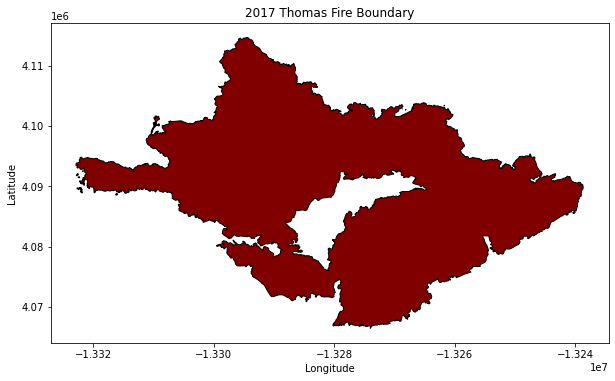

In [85]:
# Save as GeoJSON
output_path = os.path.join(data_dir, "thomas_fire_2017.geojson")
thomas_fire_2017.to_file(output_path, driver = "GeoJSON")
print(f"Thomas Fire data saved to {output_path}")

# Plot the Thomas Fire boundary
thomas_fire_2017.plot(color = "maroon", edgecolor = "black", figsize = (10, 10))
plt.title("2017 Thomas Fire Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()